## Training a CNN on synthetic data with the fastai training loops and callbacks


In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/')
from exp.nb_06 import *

import luke_model
import luke_data

In [2]:
x_train,y_train,x_valid,y_valid = luke_data.get_data()
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [3]:
c = 1
bs = 20
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [4]:
model = luke_model.Luke(cn_dropout=0.05)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
learn = Learner(model, optimizer, loss_func, data)
run = Runner(cbs=[AvgStatsCallback([accuracy])],cb_funcs=[CudaCallback])

In [5]:
from livelossplot import PlotLosses
class LivelossCallback(AvgStatsCallback):
    def __init__(self, metrics):
        super().__init__(metrics)
        self.liveloss = PlotLosses(skip_first=0)
        self.metricnames = [m.__name__ for m in metrics]
        self.logs={}
    
    def begin_epoch(self):
        super().begin_epoch()
        self.logs={}
        self.iteration = 0
        
    def after_loss(self):
        super().after_loss()
        if self.in_train:
            self.iteration += 1
            print('\r[%d, %5d] Train_loss: %.3f' %(self.epoch + 1, self.iteration, self.loss),end='')
    
    def after_epoch(self):
        super().after_epoch()
        self.logs['loss'] = self.train_stats.avg_stats[0]
        self.logs['val_loss'] = self.valid_stats.avg_stats[0]
        for i,metric in enumerate(self.metricnames):
            self.logs[metric] = self.train_stats.avg_stats[i+1].item()
            self.logs['val_'+metric] = self.valid_stats.avg_stats[i+1].item()
        self.liveloss.update(self.logs)
        self.liveloss.draw()

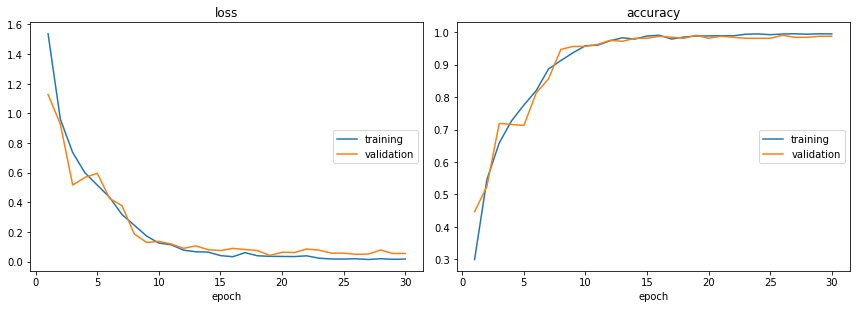

loss:
training   (min:    0.015, max:    1.537, cur:    0.018)
validation (min:    0.042, max:    1.128, cur:    0.056)

accuracy:
training   (min:    0.299, max:    0.995, cur:    0.995)
validation (min:    0.447, max:    0.991, cur:    0.988)


In [6]:
run = Runner([LivelossCallback([accuracy])],cb_funcs=[CudaCallback])
run.fit(30, learn)

### Add mlflow callback

In [ ]:
import mlflow


class AvgStatsMlFlowCallback(AvgStatsCallback):
    def __init__(
        self,
        metrics,
        experiment_name: str,
        run_name: str = "",
        params: Optional[dict] = None,
        tracking_uri: Optional[str] = None,
    ):
        super().__init__(metrics)
        self.metric_names = ["loss"] + [m.__name__ for m in listify(metrics)]
        self.experiment_name = experiment_name
        self.run_name = run_name
        self.tracking_uri = tracking_uri
        self.step = 0
        self.params = params
        self.set_up_mlflow()

    def set_up_mlflow(self):
        if self.tracking_uri:
            mlflow.set_tracking_uri(self.tracking_uri)
        print(f"mlflow tracking uri: {mlflow.get_tracking_uri()}")
        mlflow.set_experiment(self.experiment_name)

    def begin_fit(self):
        mlflow_runner = mlflow.start_run(run_name=self.run_name)
        self.run.mlflow_uuid = mlflow_runner.info.run_uuid
        if isinstance(self.params, dict):
            for key, val in self.params.items():
                mlflow.log_param(key, val)

    def after_epoch(self):
        super().after_epoch()
        self._log_metrics(self.train_stats.avg_stats, "train")
        self._log_metrics(self.valid_stats.avg_stats, "valid")
        self.step += 1

    def _log_metrics(self, stats, prefix: str):
        for name, val in zip(self.metric_names, stats):
            mlflow.log_metric(f"{prefix}_{name}", float(val), self.step)

    def after_fit(self):
        mlflow.end_run()

In [ ]:
params = dict(
    bs = 20,
    cn_dropout=0.05,
    lr=0.001,
    momentum=0.9,
    epochs=10
)

In [ ]:
mlflowcallback = partial(
    AvgStatsMlFlowCallback,
    accuracy,
    tracking_uri="http://lookilooki.root.sx:8000",
    experiment_name="demo_gpu_1",
    run_name="third_try",
    params=params,
)
    

In [ ]:
run = Runner([LivelossCallback([accuracy])],cb_funcs=[mlflowcallback, CudaCallback])
run.fit(10, learn)

In [ ]:
import mlflow
import mlflow.pytorch

In [ ]:
with mlflow.start_run(run_id=run.run_uuid):
    #mlflow.pytorch.log_model(model, "models")
    mlflow.pytorch.log_model(model, "models")

In [ ]:
# torch.save(model.state_dict(), '../../local/luke_model.pth')

In [ ]:
Runner??